<a href="https://colab.research.google.com/github/alirezasakhaei/SPML_Course2023_Homeworks/blob/main/HW06/differentially_private_SGD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.models import resnet18
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils import clip_grad_norm_
import matplotlib.pyplot as plt
import numpy as np
import torch.optim as optim
from tqdm import tqdm

## Initialization

In [ ]:
cifar_transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
     transforms.CenterCrop(28)])

mnist_transform = transforms.Compose([transforms.ToTensor(),
                                      transforms.Normalize((0.1307,), (0.3081,))])

L = 32 # group size

cifar_trainset = torchvision.datasets.CIFAR10(root='./cifar', train=True,
                                              download=True, transform=cifar_transform)
cifar_testset = torchvision.datasets.CIFAR10(root='./cifar', train=False,
                                             download=True, transform=cifar_transform)

mnist_trainset = torchvision.datasets.MNIST(root='./mnist', train=True,
                                            download=True, transform=mnist_transform)
mnist_testset = torchvision.datasets.MNIST(root='./mnist', train=False,
                                           download=True, transform=mnist_transform)

#################################### To Do (2 pts) #############################
# Define trainloader and testloader with given batch size.
# Set shuffle parameter to True for trainloader and False for testloader.
################################################################################
mnist_trainloader = torch.utils.data.DataLoader(mnist_trainset, batch_size=L, shuffle=True)
mnist_testloader = torch.utils.data.DataLoader(mnist_testset, batch_size=L, shuffle=False)

cifar_trainloader = torch.utils.data.DataLoader(cifar_trainset, batch_size=L, shuffle=True)
cifar_testloader = torch.utils.data.DataLoader(cifar_testset, batch_size=L, shuffle=False)

##################################### End ######################################

DEVICE = torch.device(torch.cuda.current_device()) if torch.cuda.is_available() else torch.device('cpu')

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
class MNIST_Net(nn.Module):
    def __init__(self):
        super(MNIST_Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        output = torch.softmax(x, dim=1)
        return output

In [ ]:
class CIFAR_Net(nn.Module):
    def __init__(self):
        super(MNIST_Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        output = torch.softmax(x, dim=1)
        return output

## differentially private SGD

In [ ]:
criterion = nn.CrossEntropyLoss()
lr=0.001

In [ ]:
###################
### Some extra functions

def collect_grads(model):
    grads = []
    for param in model.parameters():
        grad = param.grad
        grads.append(grad)
    return grads

###################

def DP_SGD(model, trainloader, criterion, lr, sigma, C):
# """
# sigma: noise scale
# C: gradient norm bound
# """
# #################################### To Do (16 pts) ##########################
    params = model.parameters()
    opt = torch.optim.SGD(model.parameters(), lr=0.001)
    for batch in tqdm(trainloader):
        for param in params:
            param.accumulated_grads = []

    # 1. For each sample, compute gradients of loss w.r.t. parameters (5 pts)
        data, labels = batch
        batch_len = data.shape[0]
        data, labels = data.to(DEVICE), labels.to(DEVICE)

        for (x, y) in zip(data, labels):

            output = model(x.unsqueeze(dim=0))
            model.zero_grad()
            loss = criterion(output, y.unsqueeze(dim=0))
            loss.backward()

            grads = collect_grads(model)

    # 2. Clip each parameter's per-sample gradient (4 pts)
            torch.nn.utils.clip_grad_norm_(grads, C)#clip_grads(grads, C)
            # print(clipped_grads)
            for (param, grad) in zip(params, grads):
                param.accumulated_grads.append(grad)

    # 3. Add noise and aggregate back accumulated grads with torch.stack (4 pts)
        for param in params:
            param.grad = torch.stack(param.accumulated_grads).mean(dim=0)
            param.grad += (torch.randn(param.grad.shape)*sigma*C/batch_len).to(DEVICE)
    # 4. Update model's weights and reset grad for the next iteration (3 pts)

        opt.step()
        model.zero_grad()
  ##################################### End ####################################

## Evaluation
Now, we want to test this algorithm on CIFAR10 and MNIST datasets.

In [ ]:
def train(model, trainloader, testloader, epochs, C, sigma):
    train_accs = []
    test_accs = []
    for epoch in range(epochs):
        model.train()
        criterion = torch.nn.CrossEntropyLoss()
        DP_SGD(model, trainloader, criterion, lr, sigma, C)
        acc_train, acc_test = calc_acc(model, trainloader, testloader)
        train_accs.append(acc_train)
        test_accs.append(acc_test)
        print(f'Epoch: {epoch} | acc_train: {acc_train}, acc_test: {acc_test}')
    return train_accs, test_accs

def calc_acc(model, trainloader, testloader):
    model.eval()
    corrects = 0
    total = 0
    for (data, labels) in trainloader:
        data, labels = data.to(DEVICE), labels.to(DEVICE)
        _, preds = model(data).max(1)
        corrects += torch.sum(preds == labels).item()
        total += data.shape[0]
    acc_train = round(corrects / total, 3)
    for (data, labels) in testloader:
        data, labels = data.to(DEVICE), labels.to(DEVICE)
        _, preds = model(data).max(1)
        corrects += torch.sum(preds == labels).item()
        total += data.shape[0]
    acc_test = round(corrects / total, 3)

    return acc_train, acc_test

### Effect of $\sigma$ (and $\epsilon$) (6 pts)
Plot accuracy vs. epoch for various noise scale $\sigma = 2, 4, 8$ for both datasets. Plot both training and testing accuracy.

Change the code above if needed.

#### MNIST

In [ ]:
SIGMAS = [2, 4, 8]
C = 4
train_accs = []
test_accs = []
epochs = 8

for i, sigma in enumerate(SIGMAS):
    print('-'*30)
    print(f'Sigma = {sigma}')
    model = MNIST_Net().to(DEVICE)
    train_acc, test_acc = train(model, mnist_trainloader, mnist_testloader, epochs, C, sigma)
    train_accs.append(train_acc)
    test_accs.append(test_acc)

------------------------------
Sigma = 2


100%|██████████| 1875/1875 [01:37<00:00, 19.18it/s]


Epoch: 0 | acc_train: 0.449, acc_test: 0.449


100%|██████████| 1875/1875 [01:35<00:00, 19.53it/s]


Epoch: 1 | acc_train: 0.711, acc_test: 0.711


100%|██████████| 1875/1875 [01:37<00:00, 19.28it/s]


Epoch: 2 | acc_train: 0.81, acc_test: 0.811


100%|██████████| 1875/1875 [01:38<00:00, 19.00it/s]


Epoch: 3 | acc_train: 0.872, acc_test: 0.873


100%|██████████| 1875/1875 [01:38<00:00, 19.09it/s]


Epoch: 4 | acc_train: 0.872, acc_test: 0.873


100%|██████████| 1875/1875 [01:37<00:00, 19.16it/s]


Epoch: 5 | acc_train: 0.851, acc_test: 0.852


100%|██████████| 1875/1875 [01:39<00:00, 18.92it/s]


Epoch: 6 | acc_train: 0.863, acc_test: 0.864


100%|██████████| 1875/1875 [01:37<00:00, 19.18it/s]


Epoch: 7 | acc_train: 0.888, acc_test: 0.889
------------------------------
Sigma = 4


100%|██████████| 1875/1875 [01:38<00:00, 19.00it/s]


Epoch: 0 | acc_train: 0.548, acc_test: 0.549


100%|██████████| 1875/1875 [01:37<00:00, 19.17it/s]


Epoch: 1 | acc_train: 0.643, acc_test: 0.644


100%|██████████| 1875/1875 [01:37<00:00, 19.22it/s]


Epoch: 2 | acc_train: 0.762, acc_test: 0.762


100%|██████████| 1875/1875 [01:38<00:00, 19.06it/s]


Epoch: 3 | acc_train: 0.798, acc_test: 0.799


100%|██████████| 1875/1875 [01:37<00:00, 19.19it/s]


Epoch: 4 | acc_train: 0.814, acc_test: 0.815


100%|██████████| 1875/1875 [01:36<00:00, 19.46it/s]


Epoch: 5 | acc_train: 0.8, acc_test: 0.801


100%|██████████| 1875/1875 [01:36<00:00, 19.34it/s]


Epoch: 6 | acc_train: 0.821, acc_test: 0.823


100%|██████████| 1875/1875 [01:36<00:00, 19.37it/s]


Epoch: 7 | acc_train: 0.829, acc_test: 0.83
------------------------------
Sigma = 8


100%|██████████| 1875/1875 [01:36<00:00, 19.43it/s]


Epoch: 0 | acc_train: 0.124, acc_test: 0.124


100%|██████████| 1875/1875 [01:35<00:00, 19.55it/s]


Epoch: 1 | acc_train: 0.539, acc_test: 0.541


100%|██████████| 1875/1875 [01:36<00:00, 19.47it/s]


Epoch: 2 | acc_train: 0.803, acc_test: 0.804


100%|██████████| 1875/1875 [01:36<00:00, 19.35it/s]


Epoch: 3 | acc_train: 0.862, acc_test: 0.863


100%|██████████| 1875/1875 [01:36<00:00, 19.47it/s]


Epoch: 4 | acc_train: 0.885, acc_test: 0.886


100%|██████████| 1875/1875 [01:37<00:00, 19.28it/s]


Epoch: 5 | acc_train: 0.877, acc_test: 0.878


100%|██████████| 1875/1875 [01:51<00:00, 16.78it/s]


Epoch: 6 | acc_train: 0.88, acc_test: 0.881


100%|██████████| 1875/1875 [02:03<00:00, 15.21it/s]


Epoch: 7 | acc_train: 0.877, acc_test: 0.878


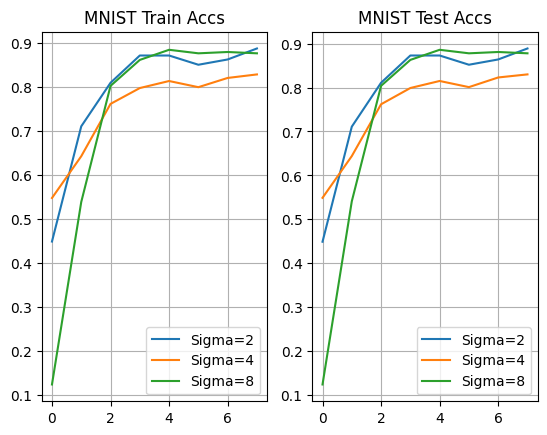

In [ ]:
plt.subplot(1, 2, 1)
plt.title('MNIST Train Accs')
plt.plot(train_accs[0], label='Sigma=2')
plt.plot(train_accs[1], label='Sigma=4')
plt.plot(train_accs[2], label='Sigma=8')
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
plt.title('MNIST Test Accs')
plt.plot(test_accs[0], label='Sigma=2')
plt.plot(test_accs[1], label='Sigma=4')
plt.plot(test_accs[2], label='Sigma=8')
plt.grid(True)
plt.legend()

#### CIFAR

In [ ]:
SIGMAS = [2, 4, 8]
C = 4
train_accs = []
test_accs = []
epochs = 8

for i, sigma in enumerate(SIGMAS):
    print('-'*30)
    print(f'Sigma = {sigma}')
    model = CIFAR_Net().to(DEVICE)
    train_acc, test_acc = train(model, cifar_trainloader, cifar_testloader, epochs, C, sigma)
    train_accs.append(train_acc)
    test_accs.append(test_acc)

In [ ]:
SIGMAS = [2, 4, 8]
C = 4
train_accs = []
test_accs = []
epochs = 8

for i, sigma in enumerate(SIGMAS):
    print('-'*30)
    print(f'Sigma = {sigma}')
    model = MNIST_Net().to(DEVICE)
    train_acc, test_acc = train(model, mnist_trainloader, mnist_testloader, epochs, C, sigma)
    train_accs.append(train_acc)
    test_accs.append(test_acc)

### Effect of $\epsilon, \delta$ (6 pts)
Plot accuracy vs. $\epsilon$ (according to formulas in the lectures) in range $(10^{-1}, 10)$ for $\delta=10^{-i}, i\in\{2, 3, 4, 5\}$ for both datasets.

#### MNIST

In [ ]:
def calc_sigma(eps, delta):
    temp = np.sqrt(2 * np.log(1.25 / delta))
    sigma = temp / eps
    return sigma

DELTAS = [10**(-i) for i in range(2, 6)]
EPS = [0.1, 1, 5, 10]
EPOCHS = 5
C = 4

ACC_train = []
ACC_test = []
for i, delta in enumerate(DELTAS):
    print('-'*30)
    print('-'*30)
    print(f'Delta = {delta}')
    ACC_train.append([])
    ACC_test.append([])
    for j, eps in enumerate(EPS):
        print('-'*30)
        print(f'Detla = {delta}, Epsilon = {eps}')
        sigma = calc_sigma(eps, delta)
        model = MNIST_Net()
        train_acc, test_acc = train(model, mnist_trainloader, mnist_testloader, epochs, C, sigma)

        ACC_train[i].append(train_acc)
        ACC_test[i].append(test_acc)

In [ ]:
for i, delta in enumerate(DELTAS):
    accs_tr = ACC_train[i]
    accs_ts = ACC_test[i]
    tr = []
    for arr in accs_tr:
        tr.append(max(arr))
    ts = []
    for arr in accs_ts:
        ts.append(max(arr))

    plt.subplot(1, 2, 1)
    plt.title(f'MNIST train | Delta = {delta}')
    plt.plot(EPS, tr)
    plt.grid(True)

    plt.subplot(1, 2, 1)
    plt.title(f'MNIST test | Delta = {delta}')
    plt.plot(EPS, ts)
    plt.grid(True)

    plt.show()
    print('-'*30)

#### CIFAR

In [ ]:
def calc_sigma(eps, delta):
    temp = np.sqrt(2 * np.log(1.25 / delta))
    sigma = temp / eps
    return sigma

DELTAS = [10**(-i) for i in range(2, 6)]
EPS = [0.1, 1, 5, 10]
EPOCHS = 5
C = 4

ACC_train = []
ACC_test = []
for i, delta in enumerate(DELTAS):
    print('-'*30)
    print('-'*30)
    print(f'Delta = {delta}')
    ACC_train.append([])
    ACC_test.append([])
    for j, eps in enumerate(EPS):
        print('-'*30)
        print(f'Detla = {delta}, Epsilon = {eps}')
        sigma = calc_sigma(eps, delta)
        model = CIFAR_Net()
        train_acc, test_acc = train(model, cifar_trainloader, cifar_testloader, epochs, C, sigma)

        ACC_train[i].append(train_acc)
        ACC_test[i].append(test_acc)

In [ ]:
for i, delta in enumerate(DELTAS):
    accs_tr = ACC_train[i]
    accs_ts = ACC_test[i]
    tr = []
    for arr in accs_tr:
        tr.append(max(arr))
    ts = []
    for arr in accs_ts:
        ts.append(max(arr))

    plt.subplot(1, 2, 1)
    plt.title(f'CIFAR train | Delta = {delta}')
    plt.plot(EPS, tr)
    plt.grid(True)

    plt.subplot(1, 2, 1)
    plt.title(f'CIFAR test | Delta = {delta}')
    plt.plot(EPS, ts)
    plt.grid(True)

    plt.show()
    print('-'*30)

### Effect of clipping bound (3 pts)
Plot train and test accuracy vs. $C=1, 2, ..., 10$ for both datasets.

#### MNIST

In [ ]:
Cs = range(1, 11)
sigma = 2
epochs = 5

train_accs = []
test_accs = []

for i, C in enumerate(Cs):
    print('-'*30)
    print(f'C = {C}')
    model = MNIST_Net().to(DEVICE)
    train_acc, test_acc = train(model, mnist_trainloader, mnist_testloader, epochs, C, sigma)
    train_accs.append(train_acc)
    test_accs.append(test_acc)

------------------------------
C = 1


100%|██████████| 1875/1875 [01:41<00:00, 18.52it/s]


Epoch: 0 | acc_train: 0.443, acc_test: 0.444


100%|██████████| 1875/1875 [01:42<00:00, 18.35it/s]


Epoch: 1 | acc_train: 0.696, acc_test: 0.698


100%|██████████| 1875/1875 [01:41<00:00, 18.54it/s]


Epoch: 2 | acc_train: 0.857, acc_test: 0.858


100%|██████████| 1875/1875 [01:43<00:00, 18.15it/s]


Epoch: 3 | acc_train: 0.869, acc_test: 0.87


100%|██████████| 1875/1875 [01:42<00:00, 18.31it/s]


Epoch: 4 | acc_train: 0.877, acc_test: 0.878
------------------------------
C = 2


100%|██████████| 1875/1875 [01:43<00:00, 18.20it/s]


Epoch: 0 | acc_train: 0.368, acc_test: 0.369


100%|██████████| 1875/1875 [01:43<00:00, 18.19it/s]


Epoch: 1 | acc_train: 0.704, acc_test: 0.706


100%|██████████| 1875/1875 [01:42<00:00, 18.30it/s]


Epoch: 2 | acc_train: 0.777, acc_test: 0.777


100%|██████████| 1875/1875 [01:42<00:00, 18.21it/s]


Epoch: 3 | acc_train: 0.811, acc_test: 0.812


100%|██████████| 1875/1875 [01:42<00:00, 18.38it/s]


Epoch: 4 | acc_train: 0.787, acc_test: 0.787
------------------------------
C = 3


100%|██████████| 1875/1875 [01:42<00:00, 18.30it/s]


Epoch: 0 | acc_train: 0.394, acc_test: 0.395


100%|██████████| 1875/1875 [01:42<00:00, 18.23it/s]


Epoch: 1 | acc_train: 0.643, acc_test: 0.644


100%|██████████| 1875/1875 [01:42<00:00, 18.29it/s]


Epoch: 2 | acc_train: 0.837, acc_test: 0.838


100%|██████████| 1875/1875 [01:42<00:00, 18.34it/s]


Epoch: 3 | acc_train: 0.851, acc_test: 0.852


100%|██████████| 1875/1875 [01:42<00:00, 18.35it/s]


Epoch: 4 | acc_train: 0.857, acc_test: 0.858
------------------------------
C = 4


100%|██████████| 1875/1875 [01:42<00:00, 18.30it/s]


Epoch: 0 | acc_train: 0.479, acc_test: 0.481


100%|██████████| 1875/1875 [01:43<00:00, 18.19it/s]


Epoch: 1 | acc_train: 0.713, acc_test: 0.714


100%|██████████| 1875/1875 [01:43<00:00, 18.08it/s]


Epoch: 2 | acc_train: 0.805, acc_test: 0.806


100%|██████████| 1875/1875 [01:44<00:00, 17.99it/s]


Epoch: 3 | acc_train: 0.869, acc_test: 0.871


100%|██████████| 1875/1875 [01:43<00:00, 18.11it/s]


Epoch: 4 | acc_train: 0.882, acc_test: 0.883
------------------------------
C = 5


100%|██████████| 1875/1875 [01:44<00:00, 18.00it/s]


Epoch: 0 | acc_train: 0.208, acc_test: 0.208


100%|██████████| 1875/1875 [01:44<00:00, 18.02it/s]


Epoch: 1 | acc_train: 0.671, acc_test: 0.672


100%|██████████| 1875/1875 [01:43<00:00, 18.12it/s]


Epoch: 2 | acc_train: 0.788, acc_test: 0.789


100%|██████████| 1875/1875 [01:43<00:00, 18.06it/s]


Epoch: 3 | acc_train: 0.815, acc_test: 0.816


100%|██████████| 1875/1875 [01:43<00:00, 18.14it/s]


Epoch: 4 | acc_train: 0.813, acc_test: 0.815
------------------------------
C = 6


100%|██████████| 1875/1875 [01:43<00:00, 18.03it/s]


Epoch: 0 | acc_train: 0.466, acc_test: 0.468


100%|██████████| 1875/1875 [01:43<00:00, 18.13it/s]


Epoch: 1 | acc_train: 0.732, acc_test: 0.733


100%|██████████| 1875/1875 [01:43<00:00, 18.11it/s]


Epoch: 2 | acc_train: 0.801, acc_test: 0.802


100%|██████████| 1875/1875 [01:45<00:00, 17.86it/s]


Epoch: 3 | acc_train: 0.825, acc_test: 0.825


100%|██████████| 1875/1875 [01:43<00:00, 18.06it/s]


Epoch: 4 | acc_train: 0.827, acc_test: 0.828
------------------------------
C = 7


100%|██████████| 1875/1875 [01:44<00:00, 17.93it/s]


Epoch: 0 | acc_train: 0.35, acc_test: 0.349


100%|██████████| 1875/1875 [01:44<00:00, 17.98it/s]


Epoch: 1 | acc_train: 0.542, acc_test: 0.543


100%|██████████| 1875/1875 [01:45<00:00, 17.74it/s]


Epoch: 2 | acc_train: 0.689, acc_test: 0.69


100%|██████████| 1875/1875 [01:44<00:00, 17.91it/s]


Epoch: 3 | acc_train: 0.763, acc_test: 0.763


100%|██████████| 1875/1875 [01:43<00:00, 18.14it/s]


Epoch: 4 | acc_train: 0.797, acc_test: 0.797
------------------------------
C = 8


100%|██████████| 1875/1875 [01:45<00:00, 17.84it/s]


Epoch: 0 | acc_train: 0.435, acc_test: 0.434


100%|██████████| 1875/1875 [01:44<00:00, 17.96it/s]


Epoch: 1 | acc_train: 0.699, acc_test: 0.7


100%|██████████| 1875/1875 [01:45<00:00, 17.79it/s]


Epoch: 2 | acc_train: 0.843, acc_test: 0.844


100%|██████████| 1875/1875 [01:44<00:00, 17.98it/s]


Epoch: 3 | acc_train: 0.867, acc_test: 0.868


100%|██████████| 1875/1875 [01:44<00:00, 18.02it/s]


Epoch: 4 | acc_train: 0.867, acc_test: 0.868
------------------------------
C = 9


100%|██████████| 1875/1875 [01:44<00:00, 17.96it/s]


Epoch: 0 | acc_train: 0.48, acc_test: 0.481


100%|██████████| 1875/1875 [01:43<00:00, 18.12it/s]


Epoch: 1 | acc_train: 0.719, acc_test: 0.72


100%|██████████| 1875/1875 [01:43<00:00, 18.18it/s]


Epoch: 2 | acc_train: 0.801, acc_test: 0.802


100%|██████████| 1875/1875 [01:43<00:00, 18.16it/s]


Epoch: 3 | acc_train: 0.812, acc_test: 0.813


100%|██████████| 1875/1875 [01:44<00:00, 17.91it/s]


Epoch: 4 | acc_train: 0.809, acc_test: 0.809
------------------------------
C = 10


100%|██████████| 1875/1875 [01:44<00:00, 18.00it/s]


Epoch: 0 | acc_train: 0.461, acc_test: 0.461


100%|██████████| 1875/1875 [01:42<00:00, 18.21it/s]


Epoch: 1 | acc_train: 0.652, acc_test: 0.653


100%|██████████| 1875/1875 [01:44<00:00, 18.00it/s]


Epoch: 2 | acc_train: 0.661, acc_test: 0.662


100%|██████████| 1875/1875 [01:44<00:00, 17.87it/s]


Epoch: 3 | acc_train: 0.667, acc_test: 0.668


100%|██████████| 1875/1875 [01:45<00:00, 17.73it/s]


Epoch: 4 | acc_train: 0.673, acc_test: 0.673


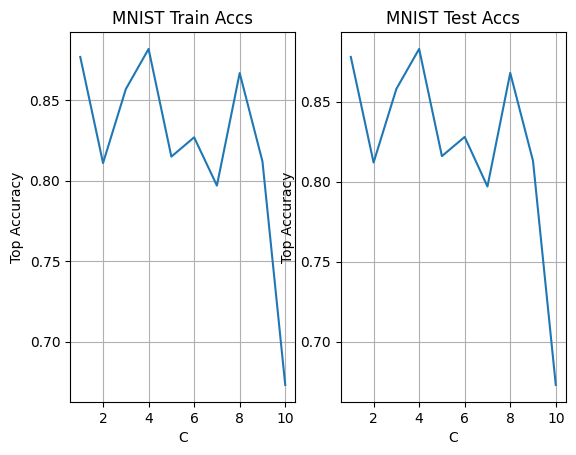

In [ ]:
BEST_ACCS_TRAIN = []
BEST_ACCS_TEST = []
for i in range(10):
    BEST_ACCS_TRAIN.append(max(train_accs[i]))
    BEST_ACCS_TEST.append(max(test_accs[i]))

plt.subplot(1, 2, 1)
plt.plot(list(Cs), BEST_ACCS_TRAIN)
plt.title('MNIST Train Accs')
plt.xlabel('C')
plt.ylabel('Top Accuracy')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(list(Cs), BEST_ACCS_TEST)
plt.title('MNIST Test Accs')
plt.xlabel('C')
plt.ylabel('Top Accuracy')
plt.grid(True)


#### CIFAR

In [ ]:
Cs = range(1, 11)
sigma = 2
epochs = 5

train_accs = []
test_accs = []

for i, C in enumerate(Cs):
    print('-'*30)
    print(f'C = {C}')
    model = CIFAR_Net().to(DEVICE)
    train_acc, test_acc = train(model, cifar_trainloader, cifar_testloader, epochs, C, sigma)
    train_accs.append(train_acc)
    test_accs.append(test_acc)

In [ ]:
BEST_ACCS_TRAIN = []
BEST_ACCS_TEST = []
for i in range(10):
    BEST_ACCS_TRAIN.append(max(train_accs[i]))
    BEST_ACCS_TEST.append(max(test_accs[i]))

plt.subplot(1, 2, 1)
plt.plot(list(Cs), BEST_ACCS_TRAIN)
plt.title('MNIST Train Accs')
plt.xlabel('C')
plt.ylabel('Top Accuracy')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(list(Cs), BEST_ACCS_TEST)
plt.title('MNIST Test Accs')
plt.xlabel('C')
plt.ylabel('Top Accuracy')
plt.grid(True)
